In [42]:
"""
This uses a GA to do the following:
1) Manage GC ratio(between 50% and 65% as done in BNT)
2) Codon optimization

"""
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
import json
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from simple_compare import SequenceComp
from codon_mapping import codon_optimize
import os

# print(os.listdir(""))
PATH_codon_to_protein = "codon_to_protein.json"
Spike_PATH = "ncov-s.fasta"
Vac_PATH = "vaccine-s.fasta"
PATH_codon_map = "vaccine_dict.json"
PATH_codon_frequency = "codon_frequency.csv"

codonProtein = json.loads(open(PATH_codon_to_protein, "r").read())
revCodonProtein = {}
for i, j in codonProtein.items():
    if j in revCodonProtein:
        revCodonProtein[j].append(i)
    else:
        revCodonProtein[j] = [i]
print(revCodonProtein)

# Reading the codon frequency table and taking off the first 
codonFrequency = open(PATH_codon_frequency, "r").read().split("\n")[1:]
dictCodonFreq = {}
for i in codonFrequency:
    fields = i.split(",")
    # Read the fields
    dictCodonFreq[fields[0]] = float(fields[2])
print(dictCodonFreq)


{'A': ['GCA', 'GCC', 'GCG', 'GCT'], 'C': ['TGC', 'TGT'], 'D': ['GAC', 'GAT'], 'E': ['GAA', 'GAG'], 'F': ['TTC', 'TTT'], 'G': ['GGA', 'GGC', 'GGG', 'GGT'], 'H': ['CAC', 'CAT'], 'I': ['ATA', 'ATC', 'ATT'], 'K': ['AAA', 'AAG'], 'L': ['CTA', 'CTC', 'CTG', 'CTT', 'TTA', 'TTG'], 'M': ['ATG'], 'N': ['AAC', 'AAT'], 'P': ['CCA', 'CCC', 'CCG', 'CCT'], 'Q': ['CAA', 'CAG'], 'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'], 's': ['TAA', 'TAG', 'TGA'], 'S': ['AGC', 'AGT', 'TCA', 'TCC', 'TCG', 'TCT'], 'T': ['ACA', 'ACC', 'ACG', 'ACT'], 'V': ['GTA', 'GTC', 'GTG', 'GTT'], 'W': ['TGG'], 'Y': ['TAC', 'TAT']}
{'UUU': 0.46, 'UCU': 0.19, 'UAU': 0.44, 'UGU': 0.46, 'UUC': 0.54, 'UCC': 0.22, 'UAC': 0.56, 'UGC': 0.54, 'UUA': 0.08, 'UCA': 0.15, 'UAA': 0.3, 'UGA': 0.47, 'UUG': 0.13, 'UCG': 0.05, 'UAG': 0.24, 'UGG': 1.0, 'CUU': 0.13, 'CCU': 0.29, 'CAU': 0.42, 'CGU': 0.08, 'CUC': 0.2, 'CCC': 0.32, 'CAC': 0.58, 'CGC': 0.18, 'CUA': 0.07, 'CCA': 0.28, 'CAA': 0.27, 'CGA': 0.11, 'CUG': 0.4, 'CCG': 0.11, 'CAG': 0.73, 'CGG

In [106]:
class OptimizeSeq:
    def __init__(self, seq):
        self.seq = seq
    def graph_gc(self, seq=None, frame=10, label=""):
        if not seq:
            seq = self.seq
        x, y = [], []
        for i in range(0, len(seq), frame):
            x.append(i)
            y.append(self.gc_content(seq, window=[i, i+frame]))
        plt.plot(x, y, label=label)
        # plt.show()
    def gc_content(self, seq=None, window=None):
        if not seq:
            seq = self.seq
        if not window:
            window = [0, len(seq)]
        # Evaluate the level of GC content within the S spike
        num_GC = len(list(filter(lambda x: x == "G" or x == "C", seq[window[0]:window[1]])))
        return num_GC / (window[1] - window[0])
    def norm_gc_cont(self, seq=None, window=None):
        if not seq:
            seq = self.seq
        if not window:
            window = [.50, 1.30]
        # Perform inverse normal to set -3-3 SD of GC content within window
        # scipy.stats.norm.cdf(x, mean, sd)
        # norm.ppf(area, mean, sd)
        # mean = mean(window), sd = (window[0]-mean)/+-3
        mean = (window[0] + window[1])/2
        sd = (window[1] - mean)/3
        # Find pdf of the particular GC content
        return norm.pdf(self.gc_content(seq), loc=mean, scale=sd)
    def calc_temp(self):
        # Calculate melting temperature for sequence
        return mt.Tm_NN(self.seq)
    def prot_similar(self, comp):
        # Compare comp with self.seq
        dissim_prot = 0
        for i in range(0, len(comp), 3):
            if not codonProtein["".join(comp[i:i+3])] == codonProtein["".join(self.seq[i:i+3])]:
                dissim_prot += 1
        return dissim_prot
    def calc_codon_freq(self, codonFreq, comp=None):
        if not comp:
            comp = self.seq
        # Given frequency table, find mean frequency of
        meanC = 0
        for i in range(0, len(comp), 3):
            meanC += codonFreq.get("".join(comp[i:i+3]), 0.1)
            # print(codonFreq[comp[i:i+3]])
        meanC /= len(comp)/3
        return meanC

    def fitness(self, comp=None, alpha=0.9, best_val=0.57):
        # Calculate (1-alpha)*codon frequency + (alpha)*GC_content
        if not comp:
            comp = self.seq
        # comp = comparison sequence to find proteins similar
        return (1-alpha)*self.calc_codon_freq(dictCodonFreq, comp)+alpha*(self.gc_content(comp) - best_val)**2
    def change(self, change_to):
        # Given seq change self.seq to change_to
        self.seq = change_to
    def evaluate(self, window=15):
        assert window % 3 == 0
        # Given the type of loss(codon differences, protein diff, or nucleotide diff, evaluate the best solution by simple discrete optimization)
        loss = 0
        best_found = list(self.seq)
        self.seq = best_found
        this_found = best_found
        best_loss = self.fitness(best_found[:window]) # self.fitness(best_found)
        for i in range(0, len(best_found), 3):
            best_loss = self.fitness(this_found[i:i+window])
            if i % 500 == 0:
                print(i, len(best_found))
            # Find all possible amino acid combinations
            current_prot = codonProtein["".join(best_found[i:i+3])]
            possible_prot = revCodonProtein[current_prot]
            for ii in possible_prot:
                this_found[i:i+3] = ii
                this_loss = self.fitness(this_found[i:i+window]) # CHANGE
                if this_loss < best_loss:
                    print("".join(best_found[i:i+50]), best_loss)
                    best_loss = float(this_loss)
                    best_found = list(this_found)
            this_loss = float(best_loss)
            this_found = list(best_found)
        return best_found, best_loss


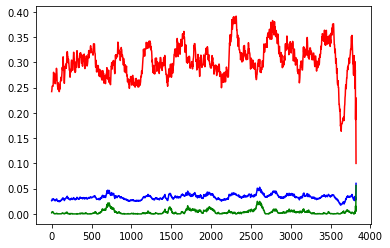

In [107]:

l = OptimizeSeq(optimized_spike)
p = list(l.seq)
x, y = [], []
y2 = []
y3 = []
for i in range(0, len(l.seq), 3):
    # p[i] = "T"
    # l.seq = "".join(p)
    x.append(i)
    y.append(l.fitness(l.seq[i:i+99]))
    y2.append(l.calc_codon_freq(dictCodonFreq, l.seq[i:i+99]))
    y3.append((l.gc_content(l.seq[i:i+99]) - 0.57)**2)

plt.plot(x, y, "b")
plt.plot(x, y2, "r")
plt.plot(x, y3, "g")
plt.show()



TGACAAAGTTGAGGCTGA 0.09560999999999997
AGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGT 0.13320999999999997
AGCGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGT 0.09560999999999997
GTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCA 0.13320999999999997
TTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAAT 0.13320999999999997
CTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAAT 0.09280999999999998
AATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGA 0.09280999999999998
GATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAG 0.03600999999999997
CTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGAT 0.028409999999999987
TCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCAC 0.05140999999999997
AGCCGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCAC 0.03780999999999998
CGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGG 0.05140999999999997
CTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAG 0.06100999999999997
AAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCA 0.05860999999999997
GTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAG

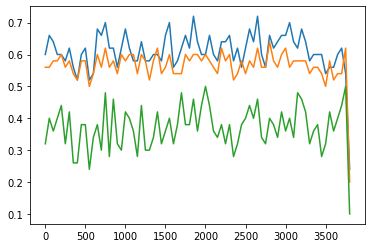

In [108]:
# Input: Genetic sequence to the spike
init_spike = str(SeqIO.read(Spike_PATH, "fasta").seq)
# For evaluation: Genetic sequence to the vaccine path
vac_encode = str(SeqIO.read(Vac_PATH, "fasta").seq)

# Version 0: Comparing the vaccine to the virus
l = SequenceComp(init_spike, vac_encode)
# l.print_compare(codonProtein)

# Version 1: Comparing the vaccine to the codon map
optimized_spike = codon_optimize(init_spike, PATH_codon_map)
l.change_seq("seq_1", optimized_spike)
# l.print_compare(codonProtein)

# Version 2: Discrete optimization
k = OptimizeSeq(str(SeqIO.read(Spike_PATH, "fasta").seq))

arr, loss = k.evaluate()
k.seq = arr
# Comp new arr with the vac
l.change_seq("seq_1", "".join(arr))
l.change_seq("seq_2", "".join(vac_encode))

# l.print_compare(codonProtein)
print(k.gc_content(arr), k.gc_content(vac_encode))

k.graph_gc(k.seq, 50)
k.graph_gc(vac_encode, 50)
k.graph_gc(init_spike, 50)

plt.show()

0.63003663003663
0.5698587127158555
0.37310308738880166


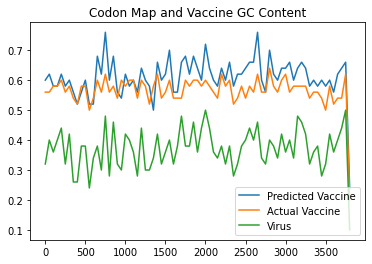

In [103]:
k.graph_gc(optimized_spike, 50, "Predicted Vaccine")
print(k.gc_content(k.seq))
k.graph_gc(vac_encode, 50, "Actual Vaccine")
print(k.gc_content(vac_encode))
k.graph_gc(init_spike, 50, "Virus")
print(k.gc_content(init_spike))
plt.legend(loc="lower right")
plt.title("Codon Map and Vaccine GC Content")
plt.show()

0.6153846153846154
0.6143380429094715
0.5698587127158555
0.37310308738880166


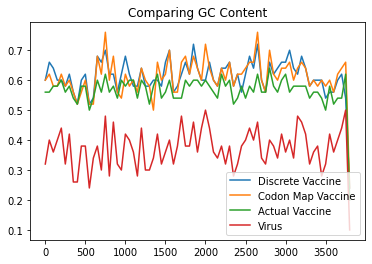

In [109]:
actual_gc = k.gc_content(vac_encode)

k.graph_gc(k.seq, 50, "Discrete Vaccine")
print(k.gc_content(k.seq))
k.graph_gc(optimized_spike, 50, "Codon Map Vaccine")
print(k.gc_content(optimized_spike))
k.graph_gc(vac_encode, 50, "Actual Vaccine")
print(actual_gc)
k.graph_gc(init_spike, 50, "Virus")
print(k.gc_content(init_spike))
plt.legend(loc="lower right")
plt.title("Comparing GC Content")
plt.show()

In [110]:
print("Version 0: Comparing the vaccine to the virus")
l = SequenceComp(init_spike, vac_encode)
l.print_compare(codonProtein, False)

print("\nVersion 1: Comparing the vaccine to the codon map")
optimized_spike = codon_optimize(init_spike, PATH_codon_map)
l.change_seq("seq_1", optimized_spike)
l.print_compare(codonProtein, False)
print(F"GC differences:\n\t{round(abs(actual_gc - k.gc_content(optimized_spike))*1000)/10}% difference")

print("\nVersion 2: Discrete optimization")
# Comp new arr with the vac
l.change_seq("seq_1", "".join(arr))
l.change_seq("seq_2", "".join(vac_encode))
l.print_compare(codonProtein, False)
print(F"GC differences:\n\t{round(abs(actual_gc - k.gc_content())*1000)/10}% difference")



Version 0: Comparing the vaccine to the virus
Nucleotide differences:
	1061
	Nucleotide: 72% similarity
Protein differences:
	2
	Protein: 99.8% similarity
Codon differences:
	922
	Codon: 28% similarity

Version 1: Comparing the vaccine to the codon map
Nucleotide differences:
	330
	Nucleotide: 91% similarity
Protein differences:
	2
	Protein: 99.8% similarity
Codon differences:
	263
	Codon: 79% similarity
GC differences:
	4.4% difference

Version 2: Discrete optimization
Nucleotide differences:
	831
	Nucleotide: 78% similarity
Protein differences:
	2
	Protein: 99.8% similarity
Codon differences:
	737
	Codon: 42% similarity
GC differences:
	4.6% difference
